# Extractor de features para estudio de células de melanopsina
**Importante:** se asume que el usuario tiene instalada la biblioteca *scipy* a través de su instalador o *Anaconda*. Además es necesario tener instalada la librería *spikelib*, que puede ser descargada rápidamente descomentando el comando de la siguiente celda.

In [114]:
#%pip install spikelib

In [9]:
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from ipywidgets import interact, interact_manual, IntSlider, Dropdown, fixed
from spikelib.utils import check_directory
from sorting import get_features, plot_raster
from scipy.io import savemat, loadmat

%matplotlib inline

## Adquisición de datos

In [116]:
exp_name = 'MR-261'
sorting_file = 'MR-261_t2.result-1.hdf5'

isi_bin = 2
bins = np.linspace(0, isi_bin * 100, 101)

## Intervalos
Intervalos de los tiempos (en segundos) de los estímulos utilizados en el experimento. Pueden ser descritos a mano o importados desde un archivo csv en caso de existir, donde las columnas deben tener por nombre *start_event* y *end_event*, mientras que los índices corresponden al nombre del estímulo a elección del usuario.

In [117]:
int_file = 'MR-261_t2-intervals.csv'
intervals = {}
try:
    df = pd.read_csv(int_file, index_col=0)
    for idx in df.index:
        intervals[idx] = tuple(df.loc[idx])
    intervals['total'] = (df['start_event'][0], df['end_event'][-1])
    
except:
    intervals['wn'] = (2.390, 1207.4)
    intervals['spont'] = (1209.4, 1521.2)
    intervals['chirp'] = (1526.8, 2188.4)
    intervals['mchirp'] = (2359.323, 3629.5)
    intervals['bflash'] = (3622.3, 3939.3)
    intervals['gflash'] = (3940.2, 4236.6)
    intervals['rflash'] = (4293.2, 4568.1)

    # Drugs
    intervals['d_chirp'] = (4641.5, 5342.1)
    intervals['d_mchirp'] = (5346.1, 6774.7)
    intervals['d_bflash'] = (6760.1, 7080.5)
    intervals['d_gflash'] = (7079.8, 7419.5)
    intervals['d_rflash'] = (7469.8, 7739.5)
            
start_point = np.array([v[0] for v in intervals.values()]) * 20000.0

## Selección de células
Se define la ruta al archivo con los índices numéricos de las células que se espera sean exploradas. Si la ruta está mal descrita, el nombre del archivo está erróneo o simplemente el archivo no existe se tomarán todas las células del archivo sorting.

**Warning:** Se considera que el archivo posee índices desde i >= 1 y por tanto se les resta a todos -1 debido a que las células de los archivos hdf5 poseen índices i >= 0.

In [118]:
# Modificar nombre del archivo
index_file = 'cell_index.txt'
try:
    file_index = open(index_file, 'r') 
    lines = file_index.readlines() 
    cell_index = [int(idx) - 1 for idx in lines]
    cell_keys = ['temp_{}'.format(int(idx) - 1) for idx in lines]
except FileNotFoundError:
    with h5py.File(sorting_file, 'r') as f:
        cell_keys = list(f['/spiketimes'].keys())

In [119]:
with h5py.File(sorting_file, 'r') as f:
    features, isi = get_features(f)
    print(features.shape)

(486, 2)


## Preparación de directorios de guardado

In [120]:
def check_exp_dir(exp):
    exp_dir = 'results/{}'.format(exp)
    if os.path.isdir('results') == False:
        os.mkdir('results')
    if os.path.isdir(exp_dir) == False:
        os.mkdir(exp_dir)        
    return exp_dir

def check_isi_dir(exp, cell_key):
    exp_dir = check_exp_dir(exp)
    isi_dir = os.path.join(exp_dir, 'isi')
    
    if os.path.isdir(isi_dir) == False:
        os.mkdir(isi_dir)
    return isi_dir    

def check_autocorr_dir(exp, cell_key):
    exp_dir = check_exp_dir(exp)
    ac_dir = os.path.join(exp_dir, 'autocorrelograms')
    cell_ac_dir = os.path.join(ac_dir, cell_key)
    
    if os.path.isdir(ac_dir) == False:
        os.mkdir(ac_dir)
    if os.path.isdir(cell_ac_dir) == False:
        os.mkdir(cell_ac_dir)        
    return cell_ac_dir

# Figuras
## Histogramas ISI y firingrate

In [121]:
def plot_isi(cell_key, savefig=False):
    with h5py.File(sorting_file, 'r') as sorting:
        spks = sorting['/spiketimes'][cell_key][...].flatten() / 20000.0
        dur = sorting['/info/duration/'][...]
        spike_rate = (spks.size / dur.astype(float)).flatten()[0]
        
        # Computing isi
        dff = np.diff(spks) if spks.any() else 0
        count, bins = np.histogram(dff, bins=np.arange(0, 1, 0.01))
        
        # Print spike_rate
        if savefig == False:
            print('Average spike rate: {} [spks/s]'.format(spike_rate))

    fig, ax = plt.subplots()
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels([0, 250, 500, 750, 1000])
    ax.set_xlabel('Time [ms]')
    ax.hist(dff, bins=np.arange(0, 1, 0.01))
    ax.set_title(cell_key)
    
    if savefig == True:
        save_file = os.path.join(check_isi_dir(exp_name, cell_key),
                                 cell_key)
        plt.savefig(save_file)
        plt.close()

## Visualizador de ISI por célula

In [122]:
interact(plot_isi,
         cell_key=Dropdown(options=cell_keys),
         savefig=fixed(False));

interactive(children=(Dropdown(description='cell_key', options=('temp_2', 'temp_6', 'temp_9', 'temp_19', 'temp…

## Guardar figuras de ISI

In [123]:
for cell in cell_keys:
    plot_isi(cell, True)

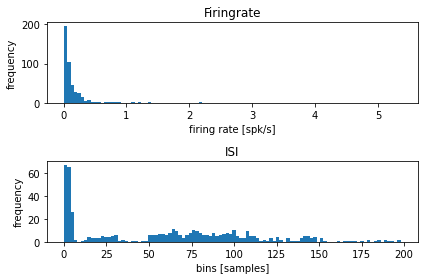

In [124]:
fig, ax = plt.subplots(2)
ax[0].hist(features[:, 0], bins=100)
ax[1].hist(features[:, 1], bins=100)
ax[0].set(title='Firingrate', xlabel='firing rate [spk/s]', ylabel='frequency')
ax[1].set(title='ISI', xlabel='bins [samples]', ylabel='frequency')
fig.tight_layout()
fig.savefig(os.path.join(check_exp_dir(exp_name),
                         'isi_fr_histogram.png'))

## Spike rates
Función para obtener *avg spike rate* de una célula a lo largo del experimento para los distintos tipos de estímulos, que retorna un arreglo con los distintos valores obtenidos. Posee una opción para printear los resultados y que omite el retorno de variables.

In [125]:
def get_spike_rates(cell_key, printable=False):
    with h5py.File(sorting_file, 'r') as sorting:
        spike_rates = {}
        spks = sorting['/spiketimes'][cell_key][...].flatten() / 20000.0
        dur = sorting['/info/duration/'][...]
        
        for key, val in intervals.items():
            spikes = spks[(spks >= intervals[key][0])*(spks < intervals[key][1])]
            spike_rates[key] = spikes.size / np.diff(intervals[key])[0]
            
            if printable == True:
                print('{} spike rate: {:.4f} [spks/s]'.format(key, spike_rates[key])) 

        if printable == False:
            data = np.array(list(spike_rates.values()))
            return data

## Visualizador de spike rates

In [126]:
interact(get_spike_rates,
         cell_key=Dropdown(options=cell_keys),
         printable=fixed(True));

interactive(children=(Dropdown(description='cell_key', options=('temp_2', 'temp_6', 'temp_9', 'temp_19', 'temp…

## Guardar datos de spike rates de todas las células

In [127]:
save_file = os.path.join(check_exp_dir(exp_name),
                         'spike_rates.csv')

data = np.zeros((len(cell_keys), len(intervals.items())))
for idx, cell in enumerate(cell_keys):
    data[idx, :] = get_spike_rates(cell, False)
    
df = pd.DataFrame(data, index=cell_keys, columns=intervals.keys())
df.to_csv(save_file, mode='w')

# Correlogramas
Se definen las funciones para obtener autocorrelogramas y crosscorrelogramas.
## Autocorrelogramas
Función para obtener y guardar matriz de autocorrelograma, además de la opción de visualización por célula y sección del experimento.

In [158]:
# Se definen los bins para el crosscorrelograma
# np.arange(limite_inferior, limite_superior, ancho)
# num_bins = (limite_superior - limite_inferior) / ancho
width = 0.001
lim = 0.1

# Se agrega la mitad del ancho de los bins en el límite inferior
# para obtener simetría en torno a 0
corr_bins = np.arange(-lim + 0.5 * width, lim, width)

def get_autocorrelogram(cell_key, int_key, savefig, save_matrix):
    fig, ax = plt.subplots()
    ax.set_xticks([-lim, -lim * 0.5, 0, lim * 0.5, lim])
    ax.set_xticklabels(np.array([-lim, -lim * 0.5, 0, lim * 0.5, lim]) * 1000)
    ax.set_xlabel('Time [ms]')
    
    corr_matrix = np.nan
    
    with h5py.File(sorting_file, 'r') as sorting:
        spks = sorting['/spiketimes'][cell_key][...].flatten() / 20000.0
        spikes = spks[(spks >= intervals[int_key][0])*(spks < intervals[int_key][1])]
        
        # Auto-correlation 
        corr_matrix = np.zeros((spikes.shape[0], spikes.shape[0]))
        for idx, _ in enumerate(spikes):
            corr_matrix[idx, :] = spikes - spikes[idx]

        corr_matrix = corr_matrix / (np.diff(intervals[int_key])[0])
        correlogram, bins = np.histogram(corr_matrix, bins=corr_bins)
        # Normalize by number of events? (from CGC.m)
        if len(spikes) > 0:
            correlogram = correlogram / (len(spikes))
                
        ax.bar(bins[1:], correlogram, 0.001)
        
        if savefig == True:
            save_file = os.path.join(check_autocorr_dir(exp_name, cell_key),
                                     '{}.png'.format(int_key))
            plt.savefig(save_file)
            plt.close()
        
    if save_matrix == True:
        return corr_matrix

## Visualizador de autoccorrelogramas

In [159]:
interact(get_autocorrelogram,
         cell_key=Dropdown(options=cell_keys),
         int_key=Dropdown(options=intervals.keys()),
         savefig=fixed(False),
         save_matrix=fixed(False));

interactive(children=(Dropdown(description='cell_key', options=('temp_2', 'temp_6', 'temp_9', 'temp_19', 'temp…

## Guardar figuras y matriz de autocorrelogramas

**Warning:** el calculo de autocorrelograma para el total del experimento por célula consume gran cantidad de recursos de cómputo y es posible que el almacenamiento de sus matrices ocupe gran cantidad de espacio en el disco. Setear *compute_total* a *True* si se desea proceder con lo anterior. 

In [160]:
from tqdm import tqdm

compute_total = False

# Create results folder and store autocorrelograms of selected cells
for cell_key in tqdm(cell_keys):
    autocorr_mat = {}
    for int_key in intervals.keys():
        if int_key == 'total' and compute_total == False:
            continue
        autocorr_mat[int_key] = get_autocorrelogram(cell_key, int_key, True, True)

    save_file = os.path.join(check_autocorr_dir(exp_name, cell_key),
                             'autocorr_data.mat')
    savemat(save_file, autocorr_mat)

100%|██████████| 39/39 [03:23<00:00,  5.21s/it]


In [21]:
angle = np.pi / 2
rot = np.array([[np.cos(angle), -np.sin(angle)],
                [np.cos(angle), np.sin(angle)]])
v = np.array([1.0, 0.0])
np.matmul(v, rot)

array([ 6.123234e-17, -1.000000e+00])

## Función de crosscorrelograma

In [150]:
# Se definen los bins para el crosscorrelograma
# np.arange(limite_inferior, limite_superior, ancho)
# num_bins = (limite_superior - limite_inferior) / ancho
width = 0.001
lim = 0.1

# Se agrega la mitad del ancho de los bins en el límite inferior
# para obtener simetría en torno a 0
corr_bins = np.arange(-lim + 0.5 * width, lim, width)

def plot_crosscorrelogram(cell0_key, cell1_key, int_key):
    fig, ax = plt.subplots()
    ax.set_xticks([-0.05, -0.025, 0, 0.025, 0.05])
    ax.set_xticklabels([-50, -25, 0, 25, 50])
    ax.set_xlabel('Time [ms]')
    
    with h5py.File(sorting_file, 'r') as sorting:
        spks1 = sorting['/spiketimes'][cell0_key][...].flatten() / 20000.0
        spks2 = sorting['/spiketimes'][cell1_key][...].flatten() / 20000.0
        spikes1 = spks1[(spks1 >= intervals[int_key][0])*(spks1 < intervals[int_key][1])]
        spikes2 = spks2[(spks2 >= intervals[int_key][0])*(spks2 < intervals[int_key][1])]

        # Cross-correlation 
        corr_matrix = np.zeros((spikes1.shape[0], spikes2.shape[0]))
        for idx, _ in enumerate(spikes1):
            corr_matrix[idx, :] = spikes2 - spikes1[idx]

        corr_matrix = corr_matrix / (np.diff(intervals[int_key])[0])
        correlogram, bins = np.histogram(corr_matrix, bins=corr_bins)
        correlogram = correlogram / ((len(spikes1) + len(spikes2)) / 2)
        
        ax.bar(bins[1:], correlogram, 0.001)

## Visualizador de crosscorrelograma

In [151]:
interact(plot_crosscorrelogram,
         cell0_key=Dropdown(options=cell_keys),
         cell1_key=Dropdown(options=cell_keys),
         int_key=Dropdown(options=intervals.keys()));

interactive(children=(Dropdown(description='cell0_key', options=('temp_2', 'temp_6', 'temp_9', 'temp_19', 'tem…

## Clustermap of ISI

/home/preyesr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/home/preyesr/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


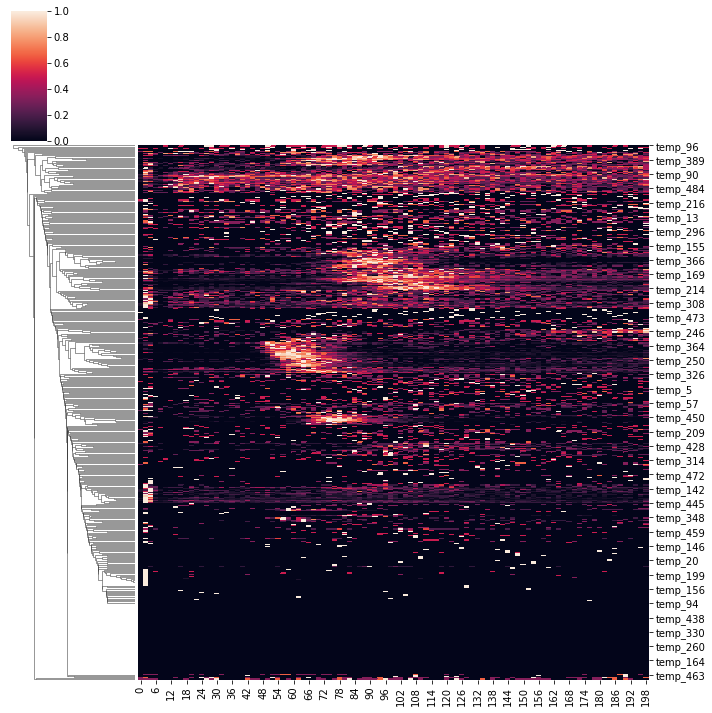

In [133]:
isi_max = isi.max(axis=1, )
isi_max[isi_max==0] = 1

save_file = os.path.join(check_exp_dir(exp_name),
                         'clustermap.png')

g = sns.clustermap(isi/isi_max[:, None], col_cluster=False, figsize=(10, 10))
g.savefig(save_file)

## Raster plot

Se genera Raster plot y se almacena en el directorio './results'.

Si se definió *cell_index* en celdas de código anteriores se incluirán en el raster solo aquellos índices que se encuentran en esta variable, en caso contrario se recomienda modificar *range_view* para el rango de las células que se desean graficar al comienzo de la siguiente celda

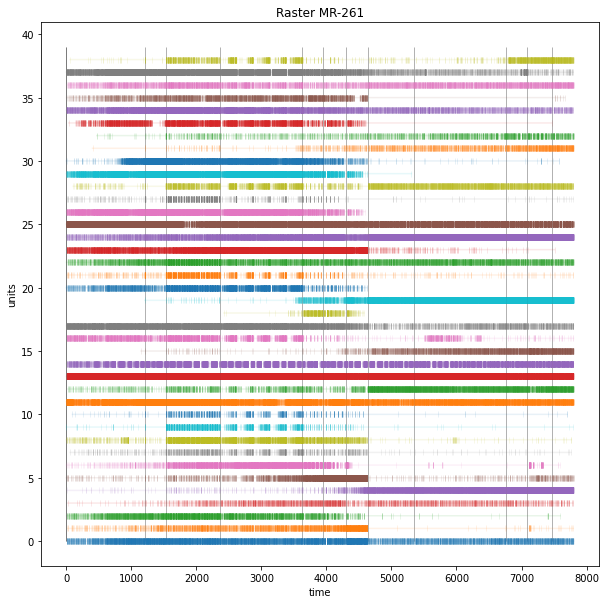

In [134]:
# Si no existe cell_index, se define un rango de células para
# incluir en el raster
range_view = [0, 200]

try:
    cell_index
    if cell_index != None:
        range_view = None
except:
    cell_index = None

save_file = os.path.join(check_exp_dir(exp_name),
                         'rasterplot.png')
save_pdf = os.path.join(check_exp_dir(exp_name),
                        'rasterplot.pdf')

with h5py.File(sorting_file, 'r') as f:
    fig, ax = plot_raster(
        sorting=f,
        range_view=range_view,
        idx_units=cell_index,
        protocols_points=start_point,
        figsize=(10, 10),
    )
    ax.set(title='Raster {}'.format(exp_name))
    fig.savefig(save_file)
    fig.savefig(save_pdf)